# BERTopic for Twi-XL

BERTopic is a LLM based topic modeling technique. The basis of this notebook was developed by Bernhard Rieder and proposes an advanced starting point for unpacking different stages of the standard BERTopic pipeline, allowing for fine-tuning at different stages. The default settings should already work well for a wide variety of datasets.

To dig deeper into BERTopic, check out these sources:

* Introductory blog post: https://www.maartengrootendorst.com/blog/bertopictutorial/
* For documentation see here: https://maartengr.github.io/BERTopic/index.html
* For a comparison with LDA, NMF, and Top2Vec see here: https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full

To run BERTopic in SANE, we are using two A10 GPUs.

### Set-up
Let's first import BERTopic and the other libraries we will need:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from IPython.display import display, HTML
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load our data from the local storage directory. Be aware that the size of the data can impact performance! Try to first experiment with smaller sets.

In [2]:
# Load the CSV dataset into a DataFrame
df = pd.read_csv('/Users/deannepacheco/Desktop/Twitter/tweets_toeslagenaffaire_merged.csv')

# Display the first few rows of the DataFrame
df.head()

/var/folders/cm/tf3h1sv10xl7_7vb0cb8s4gc0000gn/T/ipykernel_73342/270199529.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/deannepacheco/Desktop/Twitter/tweets_toeslagenaffaire_merged.csv')


id            timestamp  \
0  21208804553134080  2011-01-01 13:19:07   
1  21209049773113344  2011-01-01 13:20:06   
2  21211275954487296  2011-01-01 13:28:56   
3  21211311635439616  2011-01-01 13:29:05   
4  21568235514105857  2011-01-02 13:07:22   

                                                text full_text  \
0  @ronkNL hebben jullie een brief van de belsing...       NaN   
1  @ronkNL hoorde net van nathalie dat je dat moe...       NaN   
2  RT @financine: Let op: voor einde van het jaar...       NaN   
3  RT @Fruns: mijn vriendin is opgefokt omdat nie...       NaN   
4  Leuker kunnen we het niet maken, wel makkelijk...       NaN   

                  hashtags urls source  \
0                       []   []  twinl   
1                       []   []  twinl   
2                       []   []  twinl   
3                       []   []  twinl   
4  ['kinderopvangtoeslag']   []  twinl   

                                  author_id  
0  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694  
1  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694  
2  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694  
3  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694  
4  E2E8082D95BEF3701A81EF6EE800299F7AF5CADA

### Data preparation

We first start to do some basic preparations.

#### Removing retweets

Optional: We can start with removing retweets. This allows to focus more on the content and a fine-grained topic analysis. To investigate the "visibility" of tweets, we can return later on to a keyword-based analysis once we discovered the topics. For example, we can use representative sentences, that are output of the topic modeling, to later search their frequency across the original dataset.

Important: Removing retweets will also improve performance since it reduces the size of our data!

In [3]:
print("Amount of tweets before removing RTs: " + str(len(df)))

df = df[~df["text"].str.contains("RT ")]

print("Amount of tweets after removing RTs: " + str(len(df)))

Amount of tweets before removing RTs: 1061023
Amount of tweets after removing RTs: 399567


#### Sampling tweets

Optional 1: We might want to use with a smaller sample for testing methods more efficiently. We can select the top n tweets or get a random sample of n tweets. Generally, 10k data works best for BERTopic.

In [4]:
sample_size = 10000 # Set the sample size to the desired number of tweets

# Random sample
df_sample = df.sample(n=sample_size) # automatically excludes duplicates unless replace=True

# Sample top n (if data is sorted by timestamp, this will create a chronological subset)
# df_sample = df_sample[:sample_size]

df_sample.head(5)

id            timestamp  \
302514  1350082684744327172  2021-01-15 13:09:30   
726757  1458103688254435334  2021-11-09 15:06:24   
273       35795228312997888  2011-02-10 19:20:22   
52146   1204676918991314944  2019-12-11 07:18:53   
105632  1296456713554591744  2020-08-20 12:39:02   

                                                     text  \
302514  #Wiebes als bliksemafleider voor leugenaar @Mi...   
726757  maar @Jeugdzorgned voordat er een parlementair...   
273     Meer tijd voor ontvangers kinderopvangtoeslag:...   
52146   Zeg @Menno_Snel je snapt natuurlijk wel dat ik...   
105632  Ik vind de solidariteit van @PieterOmtzigt met...   

                                                full_text  \
302514  #Wiebes als bliksemafleider voor leugenaar @Mi...   
726757  maar @Jeugdzorgned voordat er een parlementair...   
273                                                   NaN   
52146                                                 NaN   
105632  Ik vind de solidariteit van @PieterOmtzigt met...   

                              hashtags  \
302514  ['Wiebes' 'krokedillentranen']   
726757                              []   
273                                 []   
52146             ['toeslagenaffaire']   
105632                              []   

                                                     urls source  \
302514  ['https://twitter.com/i/web/status/13500826847...  twinl   
726757  ['https://twitter.com/i/web/status/14581036882...  twinl   
273                                                [None]  twinl   
52146                                                  []  twinl   
105632  ['https://twitter.com/i/web/status/12964567135...  twinl   

                                       author_id  
302514  58B613DE2E51F88D8A29BA7B979CD3E57D059E7A  
726757  7F0A045CFC5AD9AAC216F17089A5EB46B51FF2D4  
273     DF94049E3C15EDFB5A0330A066B82A4E19DA6D49  
52146   1186BA7533D0DB7652DF4A6E6FF5EC68ABF345A9  
105632  16C8714FE85156690D4EAB4477F91E809FD82A17

Optional 2: Or we can also assign the original df to df_sample to keep all the data

In [5]:
df_sample = df

#### Get full tweets
For our tweet text, we sometimes have full tweet text (if not, the value is NaN). In general, we want to use the full tweet text whenever it is possible. We therefore fill the empty gaps for the full tweet text with the normal text and will then continue to use the full tweet text column.

In [6]:
df_sample['full_text'].fillna(df_sample['text'], inplace=True)

df_sample[['text', 'full_text']].head(5)

text  \
0  @ronkNL hebben jullie een brief van de belsing...   
1  @ronkNL hoorde net van nathalie dat je dat moe...   
4  Leuker kunnen we het niet maken, wel makkelijk...   
5  Registratienummers Kinderopvangtoeslag: Sinds ...   
6  Krijgt veel minder kinderopvangtoeslag in 2011...   

                                           full_text  
0  @ronkNL hebben jullie een brief van de belsing...  
1  @ronkNL hoorde net van nathalie dat je dat moe...  
4  Leuker kunnen we het niet maken, wel makkelijk...  
5  Registratienummers Kinderopvangtoeslag: Sinds ...  
6  Krijgt veel minder kinderopvangtoeslag in 2011...

### Data cleaning
Now we can turn to the actual cleaning of text. You can adapt the cleaning based on your needs. In this example, we adapt the cleaning to the structure of Twitter data. When using another source (e.g., television transcripts), you need to adapt this accordingly.

In [7]:
df_sample["text_clean"] = df_sample.apply(lambda row: row["full_text"].lower(), axis=1)  # all lowercase
df_sample["text_clean"] = df_sample.apply(  # remove RT
    lambda row: re.sub(r"\brt\b", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove mentions
    lambda row: re.sub("@[A-Za-z0-9_]+", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove links
    lambda row: re.sub(r"http\S+", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = (
    df_sample.apply(  # remove non-alphanumerical characters (except hashtags)
        lambda row: re.sub("[^a-z0-9]\\#'", "", row["text_clean"]), axis=1
    )
)
df_sample["text_clean"] = df_sample.apply(  # remove brackets
    lambda row: re.sub(r"[\([{})\]]", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove other arbitrary characters
    lambda row: re.sub(r"[_.!,'â€™...â€¦]", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply( # remove more arbitrary characters (caution: you might want to keep question marks)
    lambda row: re.sub(r":()?", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply( # remove spaces
    lambda row: re.sub(r"\xa0", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove tabs
    lambda row: re.sub(r"\n", " ", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove hyphens
    lambda row: re.sub(r"-", " ", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove asteriks
    lambda row: re.sub(r"\*", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove percentage
    lambda row: re.sub(r"%", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove ampersand
    lambda row: re.sub(r"&amp;", " ", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove quotation marks
    lambda row: re.sub(r'"', "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove quotation marks
    lambda row: re.sub(r"'", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove quotation marks
    lambda row: re.sub(r"“", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply(  # remove quotation marks
    lambda row: re.sub(r"’", "", row["text_clean"]), axis=1
)
emoji_pattern = re.compile(  # remove emojis [not sure if this is working]
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE,
)
df_sample["text_clean"] = df_sample.apply(
    lambda row: re.sub(emoji_pattern, "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply( # remove emojis like \u200d
    lambda row: re.sub(r"[^\w\s,]", "", row["text_clean"]), axis=1
)
df_sample["text_clean"] = df_sample.apply( # remove all digits (caution: removes years e.g. 2022; you might want to skip this)
    lambda row: re.sub(r"[0-9]", "", row["text_clean"]), axis=1
)

# Fix artifacts from cleaning procedure
df_sample["text_clean"] = df_sample.apply( # remove possibly empty spaces in string that result from cleaning
    lambda row: re.sub(r"\s+", " ", row["text_clean"].strip()), axis=1
)

print("Data cleaning finished!")

Data cleaning finished!


Let's display the result:

In [8]:
pd.set_option('display.max_colwidth', None) # to display full content
df_sample[["text", "full_text", "text_clean"]].head(5)

text  \
0   @ronkNL hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven?   
1    @ronkNL hoorde net van nathalie dat je dat moest doen voor 1 janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief   
4                      Leuker kunnen we het niet maken, wel makkelijker. Nou, nog wat makkelijker alsjeblieft, pffff...  #kinderopvangtoeslag   
5    Registratienummers Kinderopvangtoeslag: Sinds 2010 worden alle kinderdagverblijven, organisaties voor buitenscho... http://bit.ly/dI3FKm   
6  Krijgt veel minder kinderopvangtoeslag in 2011. #Belastingdienst weet het ook niet. Schrijf een brief dan krijgt u binnen 8 weken reactie!   

                                                                                                                                    full_text  \
0   @ronkNL hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven?   
1    @ronkNL hoorde net van nathalie dat je dat moest doen voor 1 janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief   
4                      Leuker kunnen we het niet maken, wel makkelijker. Nou, nog wat makkelijker alsjeblieft, pffff...  #kinderopvangtoeslag   
5    Registratienummers Kinderopvangtoeslag: Sinds 2010 worden alle kinderdagverblijven, organisaties voor buitenscho... http://bit.ly/dI3FKm   
6  Krijgt veel minder kinderopvangtoeslag in 2011. #Belastingdienst weet het ook niet. Schrijf een brief dan krijgt u binnen 8 weken reactie!   

                                                                                                                         text_clean  
0  hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven  
1    hoorde net van nathalie dat je dat moest doen voor janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief  
4                     leuker kunnen we het niet maken wel makkelijker nou nog wat makkelijker alsjeblieft pffff kinderopvangtoeslag  
5                         registratienummers kinderopvangtoeslag sinds worden alle kinderdagverblijven organisaties voor buitenscho  
6   krijgt veel minder kinderopvangtoeslag in belastingdienst weet het ook niet schrijf een brief dan krijgt u binnen weken reactie

Optional: We can again check for, and remove, duplicate documents that might have fallen through the previous filtering (RT for tweets).

In [9]:
print('Amount of documents before removing duplicates: ' + str(len(df_sample)))

df_sample = df_sample.drop_duplicates(subset='text_clean', keep='first')

print('Amount of documents after removing duplicates: ' + str(len(df_sample)))

Amount of documents before removing duplicates: 399567
Amount of documents after removing duplicates: 351032


Optional: If your docs are longer texts, we can split them into paragraphs at the newline symbol ('\n') (or any other symbol of your choice). Be careful: this can create empty strings!

Since we cleaned our documents for the newline symbol, we will not apply this technique here. However, feel free to change this in the  cleaning procedure above and run this cell afterwards.

In [18]:
split_paragraphs = []

# Create new rows for each split text
for _, row in df_sample.iterrows():
    paragraphs = row['text_clean'].split('\n')
    for para in paragraphs:
        new_row = row.copy() # duplicate existing rows with all metadata
        new_row['text_clean'] = para # overwrite the "text_clean" column with the split text
        split_paragraphs.append(new_row)

df_sample = pd.DataFrame(split_paragraphs)

df_sample[:4]
len(df_sample)

351032

If you have split the texts, let's remove rows with possibly empty strings.

In [11]:
print('Amount of documents before removing empty strings: ' + str(len(df_sample)))

df_sample = df_sample[df_sample['text_clean'].str.strip() != '']

print('Amount of documents after removing empty strings: ' + str(len(df_sample)))

df_sample[:4]

Amount of documents before removing empty strings: 351032
Amount of documents after removing empty strings: 351032


id            timestamp  \
0  21208804553134080  2011-01-01 13:19:07   
1  21209049773113344  2011-01-01 13:20:06   
4  21568235514105857  2011-01-02 13:07:22   
5  21919815555878912  2011-01-03 12:24:25   

                                                                                                                                        text  \
0  @ronkNL hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven?   
1   @ronkNL hoorde net van nathalie dat je dat moest doen voor 1 janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief   
4                     Leuker kunnen we het niet maken, wel makkelijker. Nou, nog wat makkelijker alsjeblieft, pffff...  #kinderopvangtoeslag   
5   Registratienummers Kinderopvangtoeslag: Sinds 2010 worden alle kinderdagverblijven, organisaties voor buitenscho... http://bit.ly/dI3FKm   

                                                                                                                                   full_text  \
0  @ronkNL hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven?   
1   @ronkNL hoorde net van nathalie dat je dat moest doen voor 1 janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief   
4                     Leuker kunnen we het niet maken, wel makkelijker. Nou, nog wat makkelijker alsjeblieft, pffff...  #kinderopvangtoeslag   
5   Registratienummers Kinderopvangtoeslag: Sinds 2010 worden alle kinderdagverblijven, organisaties voor buitenscho... http://bit.ly/dI3FKm   

                  hashtags    urls source  \
0                       []      []  twinl   
1                       []      []  twinl   
4  ['kinderopvangtoeslag']      []  twinl   
5                       []  [None]  twinl   

                                  author_id  \
0  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694   
1  FC4C5D6838EE682318B0C13B0DC6CEF0C33F3694   
4  E2E8082D95BEF3701A81EF6EE800299F7AF5CADA   
5  D3227D173D7E529E83005A7A0F97BB643EC18281   

                                                                                                                         text_clean  
0  hebben jullie een brief van de belsing gehad van de kinderopvangtoeslag dat je een registratienummer van nijntje door moet geven  
1    hoorde net van nathalie dat je dat moest doen voor janarie anders had je geen recht op kinderopvangtoeslag wij hebben de brief  
4                     leuker kunnen we het niet maken wel makkelijker nou nog wat makkelijker alsjeblieft pffff kinderopvangtoeslag  
5                         registratienummers kinderopvangtoeslag sinds worden alle kinderdagverblijven organisaties voor buitenscho

Nice! Data are well-prepared. Now let's first check the distribution of data we need for the analysis.

In [12]:
import pandas as pd

# Ensure the 'timestamp' column in df_sample is in datetime format
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp'], errors='coerce')

# Drop rows with invalid or missing timestamps in df_sample
df_sample = df_sample.dropna(subset=['timestamp'])

# Filter the data in df_sample to include only rows within the desired timeframe
start_date = '2018-01-01'
end_date = '2022-12-31'
df_filtered = df_sample[(df_sample['timestamp'] >= start_date) & (df_sample['timestamp'] <= end_date)]

# Check the timeframe of the filtered data
min_date = df_filtered['timestamp'].min()
max_date = df_filtered['timestamp'].max()

print(f"Filtered data timeframe: {min_date} to {max_date}")
print(f"Number of rows in the filtered data: {len(df_filtered)}")

Filtered data timeframe: 2018-01-01 04:06:07 to 2022-12-30 22:56:41
Number of rows in the filtered data: 338344


### Getting subset using the Reg-ex

In [ ]:
# Define a regex pattern to match words containing "algo", "auto", "ai", "fout", or "tech"
regex_pattern = r"\b(algo\w*|auto\w*|ai\w*|fout\w*|tech\w*|bias\w*|ethiek\w*|data\w*|transparan\w*|besluit\w*|systeem\w*|digit\w*|xeno\w*|fraude\w*|profiel\w*|model\w*|machine\w*|controle\w*|uitleg\w*|audit\w*|toezicht\w*)"
regex_pattern = r"\b(algoritme\w*|besluitvorm\w*|predict\w*|machine learning|deep learning|kunstmatige intelligentie|deepfake\w*|automati\w*|optimalisa\w*|discriminatie\w*|bias|intransparan\w*|governance|black box|white box|verantwoord\w*|ethiek\w*|veilighe\w*|betrouwbaa\w*|afweging\w*|verstor\w*|technologi\w*|infrastructuur\w*|storing\w*|bug\w*|leak\w*|privacy\w*|beveilig\w*|datalek\w*|monitor\w*|evaluatie\w*)


# Apply the regex pattern to filter rows
df_filtered_regex = df_filtered[df_filtered['text_clean'].str.contains(regex_pattern, case=False, na=False)]

# Count the number of tweets that match the regex pattern
matching_tweets_count = len(df_filtered_regex)

# Print the count
print(f"Number of tweets matching the regex pattern: {matching_tweets_count}")

Number of tweets matching the regex pattern: 9646


Filtered data timeframe: 2018-01-01 04:06:07 to 2022-12-30 22:56:41
Number of rows in the filtered data: 338344


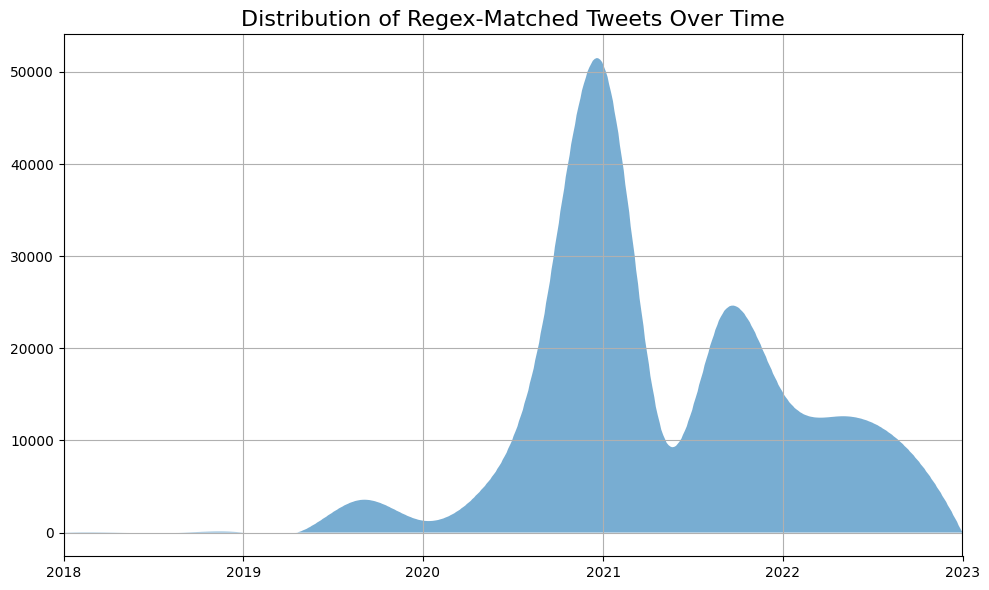

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from datetime import datetime

# Step 0: Define the regex pattern
regex_pattern = r"(Algoritme|Gegevensverwerking|algoritmen|algoritmes|Algoritmische|Automatisering|ai|Automatisch|Machine learning|Deep learning|Onterecht geweigerd|Systeemfouten|Digitale systemen|Kunstmatige Intelligentie|Programmeren|Technologie|Ai modellen|Zelflerend algoritme)"

# Step 1: Filter rows based on the regex pattern
# Assuming the column to search is named 'text'
df_filtered_regex = df_sample[df_sample['text'].str.contains(regex_pattern, case=False, na=False)]

# Step 2: Convert timestamp column
# Ensure the 'timestamp' column is in datetime format
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp'], errors='coerce')

# Drop rows with invalid or missing timestamps
df_sample = df_sample.dropna(subset=['timestamp'])

# Filter the data to include only rows within the desired timeframe
start_date = '2018-01-01'
end_date = '2022-12-31'
df_filtered = df_sample[(df_sample['timestamp'] >= start_date) & (df_sample['timestamp'] <= end_date)]

# Filter df_filtered_regex to match the timeframe of df_filtered
df_filtered_regex = df_filtered_regex[df_filtered_regex['timestamp'].between(start_date, end_date)]

# Check the timeframe of the filtered data
min_date = df_filtered['timestamp'].min()
max_date = df_filtered['timestamp'].max()

print(f"Filtered data timeframe: {min_date} to {max_date}")
print(f"Number of rows in the filtered data: {len(df_filtered)}")

# Step 4: Resample every 4 months
df_filtered_regex = df_filtered_regex.set_index('timestamp')
four_month_counts = df_filtered_regex.resample('4MS').size().reset_index()
four_month_counts.columns = ['Date', 'Count']

# Step 5: Manually add a zero or flat continuation at 2023-01-01
end_pad_date = pd.Timestamp('2023-01-01')
four_month_counts = pd.concat([
    four_month_counts,
    pd.DataFrame({'Date': [end_pad_date], 'Count': [0]})
], ignore_index=True)

# Step 6: Prepare for spline interpolation
x = four_month_counts['Date'].map(datetime.toordinal).values
y = four_month_counts['Count'].values
x_smooth = np.linspace(x.min(), x.max(), 500)

spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

# Clip negative values
y_smooth = np.clip(y_smooth, 0, None)
x_smooth_dates = [datetime.fromordinal(int(val)) for val in x_smooth]

# Step 7: Plot
plt.figure(figsize=(10, 6))
plt.fill_between(x_smooth_dates, y_smooth, alpha=0.6)
plt.title('Distribution of Regex-Matched Tweets Over Time', fontsize=16)
plt.grid(True)
plt.xlim([datetime(2018, 1, 1), datetime(2023, 1, 1)])  # ✅ lock x-axis to stop at Jan 1, 2023
plt.tight_layout()
plt.show()

In [19]:
df_filtered_regex = df_filtered_regex.drop_duplicates()

# Count the total number of tweets before applying the regex
total_tweets_before = len(df_sample)

# Filter the DataFrame using the regex
df_filtered = df_sample[df_sample['text_clean'].str.contains(regex_pattern, case=False, na=False)]

# Count the total number of tweets after applying the regex
total_tweets_after = len(df_filtered_regex)

# Count the total number of tweets after dropping duplicates
total_tweets_after_dropping_duplicates = len(df_filtered_regex)

# Print the results
print(f"Total tweets before applying regex: {total_tweets_before}")
print(f"Total tweets after applying regex: {total_tweets_after}")
print(f"Number of tweets extracted using regex: {total_tweets_after}")
print(f"Number of tweets after dropping duplicates: {total_tweets_after_dropping_duplicates}")

Total tweets before applying regex: 351032
Total tweets after applying regex: 155812
Number of tweets extracted using regex: 155812
Number of tweets after dropping duplicates: 155812


In [20]:
print(df_filtered_regex['text_clean'].head(20))

timestamp
2018-01-30 20:16:48                                              wat een ongelooflijk naief stel zeg hij moet iets gaan doen maar zij had ook wel wat mogen ondernemen kinderopvangtoeslag kind in de opvang voor als je altijd thuis bent kost meer dan het opleverd dubbeltjeopzijnkant
2018-02-15 13:32:00                                                                                                                                       moeten gezinnen waar één van de twee ouders werkt opdraaien voor de dure kinderopvangtoeslag waar tweeverdieners van profiteren
2018-02-22 07:07:44                                                                                                                                                                                                         en wie mogen dat naast de kinderopvangtoeslag ook nog betalen
2018-03-29 14:00:34                                                                                                                             

To have better results from BERTopic, in the following section, we have prepared a BERTopic tester for you to test all the parameters. Then, there is a BERTopic batch runner to first split large dataset to several batches and run them one by one automatically.

Please go head!

### Automatic BERTopic Batch Runner

#### Step 1: Load a Sentence Transformer for Embeddings

We first load a multilingual model from sentence-transformers. This model helps convert text into embeddings — high-dimensional vectors that capture semantic meaning.

**Different Sentence transformer models for embeddings**

You can use different SentenceTransformer (aka SBERT) embedding models.

Multilingual Models: Handle multiple languages for cross-lingual tasks.
- "paraphrase-multilingual-mpnet-base-v2", "distiluse-base-multilingual-cased-v1"

Paraphrase Models: Detect sentence similarity or paraphrases.
 - "paraphrase-MiniLM-L6-v2", "paraphrase-distilroberta-base-v1"

Task-Specific Models: Fine-tuned for specific NLP tasks like sentiment analysis.
 - "all-MiniLM-L6-v2", "all-distilroberta-v1"

Domain-Specific Models: Tailored for specific fields like law or medicine.
 - "legal-bert-base-uncased", "biobert-base-cased-v1.1"

You can also go [here](https://huggingface.co/models?library=sentence-transformers) for a list.

In [42]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")  # or your preferred embedding model


BERTopic is a powerful Python library for topic modeling — it can find and group similar topics in large amounts of text. One of its strengths is that it works surprisingly well with messy, online content (like tweets), even when that content includes multiple languages, spam, and a wide range of writing styles.

While you can get good results using the default settings, BERTopic is very modular, which means you can customize many parts of the process to fine-tune your results — if you have the experience. This tuned variant is based on [this tutorial](https://towardsdatascience.com/using-whisper-and-bertopic-to-model-kurzgesagts-videos-7d8a63139bdf) and the [BERTopic documentation](https://maartengr.github.io/BERTopic/), particularly the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html), [algorithm](https://maartengr.github.io/BERTopic/algorithm/algorithm.html), and [FAQ](https://maartengr.github.io/BERTopic/faq.html) sections. There are lots of great tips and explanations in these documents.

We’ll cover six key components that we can tune:

1. Embeddings – how we represent sentences numerically

2. Dimensionality Reduction – reducing the complexity of the embeddings

3. Clustering – grouping similar texts

4. Tokenization – how we split text into pieces

5. Weighting Scheme – how we decide which words matter most

6. Topic Representation – how we name/describe each topic

#### Step 2: Prepare the Data and Set Up Batches

We'll now prepare the tweet dataset, sort it by time, and break it into smaller batches. This is useful when dealing with large datasets.

In [22]:
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Output directory
output_dir = "/Users/deannepacheco/Desktop/Thesis results/Twitter"
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# STEP 0 — Filter the tweets using the regex pattern
df_filtered = df_sample[df_sample["text_clean"].str.contains(regex_pattern, case=False, na=False)]

# Ensure the 'timestamp' column is in datetime format
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')

# Drop rows with invalid or missing timestamps
df_filtered = df_filtered.dropna(subset=['timestamp'])

# Filter the data to include only rows within the desired timeframe
start_date = '2018-01-01'
end_date = '2022-12-31'
df_filtered = df_filtered[(df_filtered['timestamp'] >= start_date) & (df_filtered['timestamp'] <= end_date)]

# Sort the filtered tweet dataset by time
df_filtered = df_filtered.sort_values(by="timestamp").reset_index(drop=True)

# Extract the text and timestamps for further processing
all_docs = df_filtered["text_clean"].dropna().tolist()
all_dates = df_filtered["timestamp"].tolist()  # for time range logging

# Config
total_docs = len(all_docs)
batch_size = 10000
nr_batches = int(np.ceil(total_docs / batch_size))

print(f"📦 Total tweets (regex-matched and within timeframe): {total_docs}")
print(f"📦 Total batches: {nr_batches}")
print(f"📅 Timeframe of the filtered data: {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")

📦 Total tweets (regex-matched and within timeframe): 266981
📦 Total batches: 27
📅 Timeframe of the filtered data: 2018-01-30 20:16:48 to 2022-12-30 22:56:41


In [43]:
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Output directory
output_dir = "/Users/deannepacheco/Desktop/Thesis results/Twitter"
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# STEP 0 — Filter the tweets using the regex pattern
df_filtered = df_sample[df_sample["text_clean"].str.contains(regex_pattern, case=False, na=False)]

# Ensure the 'timestamp' column is in datetime format
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')

# Drop rows with invalid or missing timestamps
df_filtered = df_filtered.dropna(subset=['timestamp'])

# Filter the data to include only rows within the desired timeframe
start_date = '2018-01-01'
end_date = '2022-12-31'
df_filtered = df_filtered[(df_filtered['timestamp'] >= start_date) & (df_filtered['timestamp'] <= end_date)]

# Sort the filtered tweet dataset by time
df_filtered = df_filtered.sort_values(by="timestamp").reset_index(drop=True)

# Extract the text and timestamps for further processing
all_docs = df_filtered["text_clean"].dropna().tolist()
all_dates = df_filtered["timestamp"].tolist()  # for time range logging

# Config
total_docs = len(all_docs)
batch_size = 10000
nr_batches = int(np.ceil(total_docs / batch_size))

print(f"📦 Total tweets (regex-matched and within timeframe): {total_docs}")
print(f"📦 Total batches: {nr_batches}")
print(f"📅 Timeframe of the filtered data: {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")

📦 Total tweets (regex-matched and within timeframe): 9646
📦 Total batches: 1
📅 Timeframe of the filtered data: 2018-01-03 11:36:52 to 2022-12-30 18:51:34


#### Step 3: Customize BERTopic Parameters

Here we fine-tune different components of BERTopic. Each one plays a specific role in how topics are discovered:

**Tunable parameters in UMAP**

N_components- number of dimensions to reduce. (default:5)
- Lower values may lose information but improve clustering efficiency.
- Higher values retain more details but may make clustering harder

N_neighbours- number of nearest neighbours considered. (Default:15)
- Lower values emphasize local structures(useful for fine-grained topics).
- Higher values emphasize global structures (useful for broad, general topics).

Min_dist- minimum distance between points in a reduced space
- Lower values create dense cluster
- Higher values spread clusters apart


**Tunable parameters in Clustering- HDBSCAN**

Min_cluster_size- the minimum documents per cluster
- Lower values allow small topics to emerge
- Larger values force larger, general topics

Min_samples- controls how strictly a point belongs to a cluster
- Lower values lead to more clusters
- Higher topics remove noise but may merge distinct topics

Cluster_selection_method- determines how topics are framed
- “eom”(Excess of Mass- default)- finds dense clusters
- “Leaf”- allows more topic granularity


**K-MEANS**

N_clusters- forces the exact number of topics
- Lower amount of clusters makes them broad and mixed
- Larger amount of clusters make them too specific

**Tokenizing**

Adjusting stopwords
helps remove uninformative words, but be careful not to exclude meaningful ones.

min_df

- Increasing filters out more rare terms, reducing noise.
- Decreasing includes more rare terms, increasing detail but also noise.

ngram_range
expanding captures more context (e.g., adding trigrams), but increases dimensionality.

**Weighting Scheme**

Reducing frequent words: True
- Downweights common words across topics, making topics more distinct and keywords more meaningful.
False
- Treats all words equally, so frequent terms might dominate and reduce topic clarity.


**Representation Tuning**

KeyBERT() – Extracts contextually relevant keywords using BERT embeddings for meaningful topic representation.

MaximalMarginalRelevance() – Balances relevance and diversity of keywords.

Simple() – Returns top keywords by c-TF-IDF score (fast but basic).

PartiallyRedundant() – Allows some repetition while maintaining clarity.

MMR() – Another name for MaximalMarginalRelevance().



In [44]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

# Download Dutch stopwords
nltk.download('stopwords')
dutch_stopwords = stopwords.words('dutch')

# Load custom stopwords from a file
custom_stopwords_file = "/Users/deannepacheco/Desktop/Thesis results/Stopwords.rtf"  # Replace with the path to your file
with open(custom_stopwords_file, "r") as file:
    custom_stop_words = [line.strip() for line in file.readlines()]

# Combine Dutch stopwords and custom stopwords
combined_stop_words = list(set(dutch_stopwords + custom_stop_words))

# Print the first few stopwords to verify
print("Combined Stopwords:", combined_stop_words[:10])

# Define models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=10)
hdbscan_model = KMeans(n_clusters=30)
vectorizer_model = CountVectorizer(stop_words=combined_stop_words, ngram_range=(1, 2), min_df=5)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
representation_model = KeyBERTInspired()

Combined Stopwords: ['', 'hoe', 'u', 'maar', 'alles', 'wezen', 'dus', 'was', 'na', 'mijn']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deannepacheco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Step 4: Run BERTopic in the First Batch and Test the Paramesters

Before we run the BERTopic in all batches, let's first try the paramesters with batch 0. This is very important. Running the whole dataset consumes lots of time. So let's first test and find a suitable parameter in Step 4. Then, we can run all the batches in Step 5. 

This Step usually takes more efforts and time than other Steps. Remeber to be patient :)

In [45]:
# --- Setup for Batch 1 ---
batch = 0
batch_start = batch * batch_size
batch_end = min((batch + 1) * batch_size, total_docs)

docs = all_docs[batch_start:batch_end]
dates = all_dates[batch_start:batch_end]

print(f"\n🚀 [TEST RUN] Starting batch {batch + 1}/{nr_batches} — {len(docs)} tweets")

# Time range info
start_time_str = pd.to_datetime(dates[0]).strftime("%Y-%m-%d %H:%M:%S")
end_time_str = pd.to_datetime(dates[-1]).strftime("%Y-%m-%d %H:%M:%S")
print(f"🕒 Batch {batch + 1} covers: {start_time_str} → {end_time_str}")

# Generate embeddings
embeddings = sentence_model.encode(docs, batch_size=48, show_progress_bar=True)

# Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=sentence_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

# Run topic modeling
topics, probs = topic_model.fit_transform(docs, embeddings)


🚀 [TEST RUN] Starting batch 1/1 — 9646 tweets
🕒 Batch 1 covers: 2018-01-03 11:36:52 → 2022-12-30 18:51:34


Batches: 100%|██████████| 201/201 [05:19<00:00,  1.59s/it]
2025-04-27 16:04:46,294 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-27 16:05:09,055 - BERTopic - Dimensionality - Completed ✓
2025-04-27 16:05:09,066 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-27 16:05:09,236 - BERTopic - Cluster - Completed ✓
2025-04-27 16:05:09,276 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-27 16:05:42,941 - BERTopic - Representation - Completed ✓


Now you have get the result of batch 0. Let's check the topics below. 

If the topics are not good, you can adjust the parameters above and rerun it.

In [46]:
# Get topic info
topic_model.get_topic_info()

Topic  Count  \
0       0    664   
1       1    586   
2       2    506   
3       3    505   
4       4    463   
5       5    463   
6       6    450   
7       7    450   
8       8    449   
9       9    446   
10     10    431   
11     11    420   
12     12    411   
13     13    403   
14     14    326   
15     15    325   
16     16    309   
17     17    243   
18     18    235   
19     19    229   
20     20    218   
21     21    200   
22     22    199   
23     23    178   
24     24    165   
25     25    153   
26     26     93   
27     27     76   
28     28     41   
29     29      9   

                                                                                                                       Name  \
0           0_toeslagenaffaire algoritmes_algoritmes toeslagenaffaire_toeslagenaffaire algoritme_algoritme toeslagenaffaire   
1                                                 1_fouten overheid_overheid fouten_overheid fout_toeslagenaffaire overheid   
2                                             2_toeslagenaffaire kabinet_demissionaire kabinet_demissionair kabinet_premier   
3           3_belastingdienst toeslagenschandaal_toeslagenschandaal belastingdienst_toeslagenschandaal_belastingdienst wist   
4                                                             4_discriminerende_gediscrimineerd_discriminatie_discrimineren   
5                            5_groningen toeslagenaffaire_toeslagenaffaire coronacrisis_toeslagenaffaire groningen_overheid   
6             6_toeslagenschandaal kinderen_kinderen toeslagenschandaal_toeslagenaffaire kinderen_kinderen toeslagenaffaire   
7   7_kinderopvangtoeslag belastingdienst_belastingdienst kinderopvangtoeslag_fout kinderopvangtoeslag_belastingdienst fout   
8                             8_toeslagenaffaire fouten_fouten toeslagenaffaire_fout toeslagenaffaire_toeslagenaffaire fout   
9                                                               9_nederland_nederlanders_foute politieke_toeslagenschandaal   
10                                                                      10_democratie_rechtstaat_democratisch_democratische   
11                                         11_toeslagenschandaal_schandaal_toeslagenaffaire man_toeslagenaffaire gedupeerde   
12   12_fout kinderopvangtoeslag_kinderopvangtoeslag affaire_toeslagenaffaire kinderen_toeslagenaffaire kinderopvangtoeslag   
13                                                                            13_mensen fouten_fouten maken_fouten_toegeven   
14          14_toeslagenschandaal toeslagenaffaire_slachtoffers toeslagenaffaire_toeslagenschandaal_toeslagenaffaire mensen   
15                         15_toeslagenschandaal weer_rutte toeslagenschandaal_toeslagenschandaal_toeslagenaffaire vergeten   
16      16_toeslagenschandaal_toeslagenaffaire toeslagenschandaal_parlementaire enquête_toeslagenschandaal toeslagenaffaire   
17                                                                    17_rechterlijke_rechters_rechterlijke macht_rechtbank   
18                                                            18_onze rechtsstaat_rechtstaat_rechtsstaat_rechterlijke macht   
19                                       19_kabinet toeslagenaffaire_vanwege toeslagenaffaire_rol toeslagenaffaire_politiek   
20                                   20_kinderen toeslagenschandaal_gedupeerde toeslagenaffaire_toeslagenschandaal_we maken   
21                                                21_gedupeerden toeslagenaffaire_toeslagenaffaire fout_fraudeaanpak_fraude   
22                     22_amnesty_belastingdienst discrimineerde_discriminatie toeslagenaffaire_toeslagenaffaire algoritmes   
23                                23_vanwege toeslagenschandaal_toeslagenaffaire belastingdienst_onrechtmatig_onrechtmatige   
24                                                           24_twitter_tweet_weer toeslagenaffaire_toeslagenschandaal fout   
25                                               25_schulden toeslagenaffaire_sch

Let's also visualize the result.

In [47]:
topic_model.visualize_documents(
    docs=docs,
    embeddings = sentence_model.encode(docs, batch_size=48, show_progress_bar=True),
    hide_annotations=True,)

Batches: 100%|██████████| 201/201 [01:48<00:00,  1.84it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'hovertext': array([None], dtype=object),
              'marker': {'color': '#CFD8DC', 'opacity': 0.5, 'size': 5},
              'mode': 'markers+text',
              'name': 'other',
              'showlegend': False,
              'type': 'scattergl',
              'x': {'bdata': 'AADAfw==', 'dtype': 'f4'},
              'y': {'bdata': 'AADAfw==', 'dtype': 'f4'}},
             {'hoverinfo': 'text',
              'hovertext': array(['toeslagenaffaire dit is precies waarom je niet voor grote groepen toeslagen moet inschatten met behulp van algoritmes',
                                  'de algoritmes achter het toeslagenschandaal gebruikte digitale en algoritmische componenten hebben wel degelijk veel overeenkomsten met componenten waar een informatieprofessional mee te maken zou krijgen in zoek en aanbevelingsscenarios voginip',
                                  'en algoritmen waarvan we bijv middels toeslagenaffaire en afghanistan hebben kunnen leren dat de overheid hier introspectie nodig heeft advies socratisch dialoog om te komen tot eenduidige discussie over bijv informatie die openbaar is en spionage',
                                  ...,
                                  'volgens deze techniekfilosofe was de toeslagenaffaire het topje van de ijsberg toeslagenaffaire vvd rutte via',
                                  'dat is lastig ik ga er nu al van uit dat big tech hier exact het zelfde gaat doen als in de states accounts opschorten als dat mee valt dan moeten we meeliften op het negatieve effect van de toeslagenaffaire en hopen dat er meer mensen wakker worden',
                                  'de overheid gebruikt zelf ook algoritmes bijv in de toeslagenaffaire ik denk dat we ons hier minder zorgen moeten maken over de berichtgeving dan over de gevolgen van die algoritmes het kan inderdaad zo mis gaan'],
                                 dtype=object),
              'marker': {'opacity': 0.5, 'size': 5},
              'mode': 'markers+text',
              'name': ('0_toeslagenaffaire algoritmes_' ... 'ire_toeslagenaffaire algoritme'),
              'text': array(['', '', '', ..., '', '', ''], dtype=object),
              'textfont': {'size': 12},
              'type': 'scattergl',
              'x': {'bdata': ('75QvQdCTLkH0YzFBPw4wQR5wNkGsVT' ... 'FFyi9BH9s0QQLAPUFf2zxB8owyQQ=='),
                    'dtype': 'f4'},
              'y': {'bdata': ('HDOIP10UhD9e/7M/fyS3P82vG0CNU9' ... '9rvZg/4eYMQDyklz/13NQ/dqfEPw=='),
                    'dtype': 'f4'}},
             {'hoverinfo': 'text',
              'hovertext': array(['de staat verdeel en heers heel oude techniek doel ongestoord andere zaken kunnen regelen danwel geen onrust over zaken als bijv toeslagenaffaire rol midden oosten etc denk ook aan negatieve rente icm de stand van financiële markten',
                                  'en als het dan alsnog fout gaat waar doen we het dan voor waarom al die lastige maatregelen op basis van de mooie woorden van onze overheid en dat beste mensen is waarom vertrouwen zo belangrijk is waarom de toeslagenaffaire niet zonder gevolgen kan blijven',
                                  'u gaat uit van wantrouwen net als zovelen ook soms de overheid waar ironie de toeslagenaffaire een voorbeeld van is ik ga niet uit van een bewuste fout',
                                  ...,
                                  'ik vertrouw de overheid zo lang als het klopt wat de overheid doet de toeslagenaffaire is fout en zo zullen er meer dingen zijn die fout zijn',
                                  'kan er geen streep worden gezet onder die toeslagenaffaire toeslagenschandaal we moeten toch ook weer een keer met elkaar verder dus niet blijven hameren op wat er allemaal fout ging in het verleden maar positief naar de toekomst kijken',
                                  'weer een leugen om fout beleid te rechtvaardigen ook bij de toeslagenaffaire is het jaren zo gegaan'],
              

Once you find suitable parameters for your data, you can go head to the Automatic Batch Runner!

#### Step 5: Run BERTopic in Batches

This loop processes the data in chunks. For each batch of tweets, we:

Generate sentence embeddings

Run BERTopic with all the custom components

Save the topic information and per-document results

In [ ]:
for batch in tqdm(range(nr_batches), desc="🔁 Processing Batches", unit="batch"):
    batch_start = batch * batch_size
    batch_end = min((batch + 1) * batch_size, total_docs)

    docs = all_docs[batch_start:batch_end]
    dates = all_dates[batch_start:batch_end]

    batch_str = str(batch).zfill(2)
    print(f"\n🚀 Starting batch {batch + 1}/{nr_batches} — {len(docs)} tweets")

    # Time range for this batch
    start_time_str = pd.to_datetime(dates[0]).strftime("%Y-%m-%d %H:%M:%S")
    end_time_str = pd.to_datetime(dates[-1]).strftime("%Y-%m-%d %H:%M:%S")
    print(f"🕒 Batch {batch + 1} covers: {start_time_str} → {end_time_str}")

    start_time = time.time()

    # Generate embeddings
    embeddings = sentence_model.encode(docs, batch_size=48, show_progress_bar=True)

    # Run BERTopic
    topic_model = BERTopic(
        embedding_model=sentence_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(docs, embeddings)

    # Save outputs
    documents = topic_model.get_document_info(docs)
    topic_info = topic_model.get_topic_info()

    documents.to_csv(os.path.join(results_dir, f"twitter_batch{batch_str}_documents.csv"), sep=";")
    topic_info.to_csv(os.path.join(results_dir, f"twitter_batch{batch_str}_topic_info.csv"), sep=";")

    duration = time.time() - start_time
    print(f"✅ Finished batch {batch + 1}/{nr_batches} in {duration:.2f} seconds")
    print(f"📁 Results saved to: twitter_batch{batch_str}_*.csv\n")

Now we have finished all the batch running. Let's then check the topic_info of batch 1.

In [ ]:
topic_info_b01 = pd.read_csv(os.path.join(results_dir, "twitter_batch01_topic_info.csv"), sep=';')
topic_info_b01.head(5)

If everything is correct, let's then merge all the output document in the following section. Or you might want to adjust some parameters or stopwords above.

### Merge All The Outputs

Now we have got all the results of each batch. For overall analysis, we need to merge all the topics and documents together seperately.

#### Step 1: Merge Top 10 Topics in Each Batch

We first select top 10 topics of each batch and merge them together in a dataframe. It helps us to get the main topics across all the batches.

In [ ]:
import pandas as pd
import os

def merge_top_topics(results_dir, top_n=10): # you can change the number of topics you want here
    """
    Merges the top N topics from each batch's topic_info file.

    Args:
        results_dir: The directory containing the batch results.
        top_n: The number of top topics to consider from each batch.

    Returns:
        A pandas DataFrame containing the merged top topics.
    """
    all_top_topics = []
    for filename in os.listdir(results_dir):
        if filename.startswith("twitter_batch") and filename.endswith("_topic_info.csv"):
            filepath = os.path.join(results_dir, filename)
            try:
                df = pd.read_csv(filepath, sep=';')
                # Exclude the outlier topic (-1)
                top_topics_df = df[df["Topic"] != -1].nlargest(top_n, "Count")
                all_top_topics.append(top_topics_df)
            except pd.errors.EmptyDataError:
                print(f"Warning: Skipping empty file: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if all_top_topics:
        merged_df = pd.concat(all_top_topics, ignore_index=True)
        return merged_df
    else:
        print("No valid topic info files found.")
        return pd.DataFrame()

merged_topics = merge_top_topics(results_dir)

if not merged_topics.empty:
    merged_topics.head()

Then, we convert this dataframe to csv file and save it in local directory.

In [ ]:
# Save to CSV if the DataFrame is not empty
if not merged_topics.empty:
    output_path = os.path.join(results_dir, "merged_top_topics.csv")
    merged_topics.to_csv(output_path, sep=";", index=False)
    print(f"✅ Merged top topics saved to: {output_path}")
else:
    print("⚠️ Skipped saving: merged_topics is empty.")

Now you have got the csv file of merged top 10 topics! You can go to spreasheet to check the result and do manual labelling to assign them into larger catergories.

When you finish the manual labeling, you can assign them to merged document dataframe in Step 4.

#### Step 2: Merge Documents of Batches

We also want to merge the document results into a single file.

This step ensures that we can analyze the full set of topic assignments across all tweets at once.

In [ ]:
import os
import re
import pandas as pd

# Load all the document CSV file in the output directory
directory = results_dir
pattern = re.compile(r"twitter_batch(\d+)_documents\.csv")

files_with_index = []
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        index = int(match.group(1))
        files_with_index.append((index, filename))

files_with_index.sort()

dfs = []
for index, filename in files_with_index:
    path = os.path.join(directory, filename)
    try:
        # ✅ Use semicolon separator!
        df = pd.read_csv(path, sep=";")

        # Drop index column if present (was likely saved earlier)
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])

        # Optional: track the batch source
        df["batch_index"] = index

        dfs.append(df)
    except Exception as e:
        print(f"⚠️ Failed to load {filename}: {e}")

# Merge and save
if dfs:
    merged_df = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join(directory, "twitter_merged_documents.csv")
    merged_df.to_csv(output_file, sep=";", index=False)  # ✅ Save with same semicolon format
    print(f"✅ Merged {len(files_with_index)} files into {output_file}")
else:
    print("❌ No files were loaded.")


After saving the merged dataframe into csv file, we can load it to check whether there is any mistake in it.

In [ ]:
# Load the merged CSV file into a DataFrame
merged_path = os.path.join(results_dir, "twitter_merged_documents.csv")
merged_df = pd.read_csv(merged_path, sep=';')

# Display the first few rows of the DataFrame
merged_df.head(5)

#### Step 3: Assign timestamp from original dataset to the merged document dataframe

The result of topic modeling ususally does not include a timestamp of each topic and document. While it is very important to do time series analysis in cross-media research, such as analyzing the topic trend across time, topic composition and so on. We then go back to the cleaned data we have before BERTopic and try to assign the timestamp from it to our merged result document df.

Let's first check if there are same content in "text_clean" column of cleaned data as the content in "Document" column of merged document df.

In [ ]:
# How many Document entries have an exact match in text_clean?
matches = merged_df["Document"].isin(df_sample["text_clean"])
print(f"✅ Matched {matches.sum()} out of {len(merged_df)} documents ({matches.mean() * 100:.2f}%)")

Once we find them match each other, we can assign the timestamp in the merged document dataframe.

In [ ]:
# Merge in timestamp
final_df = pd.merge(
    merged_df,
    df_sample[['text_clean', 'timestamp']],
    left_on='Document',
    right_on='text_clean',
    how='left'
)

# Optional cleanup: drop redundant text_clean column
final_df.drop(columns=['text_clean'], inplace=True)

# Save for visualization
final_df.to_csv("bertopic_output_with_timestamp.csv", sep=";", index=False)

print("✅ Timestamp added successfully and data saved.")


Let's check the merged dataframe.

In [ ]:
final_df.info()
final_df.head(5)

Good! You have assigned the timestamp to the merged document dataframe. Now we only need one last step - assign the custom label you have finished after step 1 to the new dataframe with timestamp. Then you are ready for visualization!

#### Step 4: Merge the top 10 topics' custom label to the merged document dataframe

Once you finish the manual label after Step 1, let's load the csv with custom label back.

In [ ]:
df_label = pd.read_csv('/Users/tristan/Desktop/ERP Data Sprint I/filtered_custom_labels_FINALL.csv', sep=',') # change to your own path and file with custom label here
df_label.head(5)

Then, we assign the custom label to the data if their batch and topics in two different dataframes both match each other.

In [ ]:
# Step 1: Merge on both batch and topic
df_merged_labeled = pd.merge(
    final_df,
    df_label[['Batch', 'Topic', 'Custom Label']],
    left_on=['batch_index', 'Topic'],
    right_on=['Batch', 'Topic'],
    how='left'
)

# Step 2: Fill missing labels with 'Other Topics'
df_merged_labeled['Custom Label'] = df_merged_labeled['Custom Label'].fillna('Other Topics')

# Step 3: Optional cleanup (drop 'batch' column from df_label)
#df_merged_labeled = df_merged_labeled.drop(columns=['batch'])

# ✅ Done
print("✅ Custom labels merged successfully.")


In [ ]:
df_merged_labeled.head(5)

Nice! Now we have assign all the tweets with custom label. While this dataframe also includes "other topics", which we would not use for the visualization and future analysis. Let's then filter out "other topics".

In [ ]:
df_merged_labeled.to_csv('/Users/tristan/Desktop/ERP Data Sprint I/tweets_toeslagenaffaire/results/df_merged_labeled.csv', sep=';', index=False)

In [ ]:
# Filter out rows labeled as "Other Topics"
top10_document = df_merged_labeled[df_merged_labeled["Custom Label"] != "Other Topics"]

top10_document.head(5)

In [ ]:
# Save the filtered DataFrame to a new CSV file
top10_document.to_csv('/Users/tristan/Desktop/ERP Data Sprint I/tweets_toeslagenaffaire/results/twitter_top10_documents.csv', sep=';', index=False)

print("✅ Filtered data saved successfully.")

### Visualization

Now let's visualize the main topics. Here we offer three visualizations often used by cross-media scholars, inlcuding topic over time (streamgraph), topic composition over time (streamgraph) and topic keyword visualization (bubble chart).

#### Reload top10_document (optional)
If you lost your session, you can reload your top10_document here for the following visualization tasks.

In [ ]:
top10_document = pd.read_csv('/Users/tristan/Desktop/ERP Data Sprint I/tweets_toeslagenaffaire/results/twitter_top10_documents.csv', sep=';')
top10_document['timestamp'] = pd.to_datetime(top10_document['timestamp'])

In [ ]:
top10_document.info()

To keep all the color aligning with the same topics across different visualization, we first assign them together.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate overall proportions for sorting
label_proportions = top10_document['Custom Label'].value_counts(normalize=True)

# Sort labels from highest to lowest overall proportion
label_order = label_proportions.index.tolist()

# Get colors from tab20c colormap in sorted order
cmap = plt.get_cmap('tab20c')
colors = [cmap(i) for i in range(len(label_order))]

# Explicit color mapping: labels → colors
color_mapping = dict(zip(label_order, colors))

Then, we generate different visualization.

#### Topic Dynamics

**Streamgraph of Topic Trends**

This visualization creates a streamgraph-style plot, it displays the raw weekly counts of each topic. This gives an accurate view of short-term spikes or bursts in topic frequency.

In [ ]:
# streamgraph
import matplotlib.pyplot as plt
import pandas as pd

# Ensure timestamp is datetime
top10_document['timestamp'] = pd.to_datetime(top10_document['timestamp'])

# Optional: aggregate to daily/weekly/monthly counts
top10_document['date'] = top10_document['timestamp'].dt.to_period('W').dt.start_time

# Pivot the table to wide format for streamgraph
pivot_df = top10_document.groupby(['date', 'Custom Label']).size().unstack(fill_value=0)

# Sort columns by total volume if needed
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.stackplot(pivot_df.index, pivot_df.T.values, labels=pivot_df.columns)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("Custom Topic Labels Over Time (Streamgraph Style)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Document Count")
plt.tight_layout()
plt.show()


**Streamgraph of Topic Trends (Smoothened)**

This version creates a streamgraph-style plot showing how the top topics evolve over time, with smoothed lines to reduce noise and better highlight long-term trends.

In [ ]:
top10_document['date'] = top10_document['timestamp'].dt.to_period('W').dt.start_time
pivot_weekly = top10_document.groupby(['date', 'Custom Label']).size().unstack(fill_value=0)

# Sort columns explicitly
pivot_weekly = pivot_weekly[label_order]

pivot_smoothed = pivot_weekly.rolling(window=4, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 7))
ax.stackplot(
    pivot_smoothed.index,
    pivot_smoothed.T.values,
    labels=pivot_smoothed.columns,
    colors=[color_mapping[label] for label in pivot_smoothed.columns],
    baseline='sym'
)

ax.set_title("Twitter Topics Over Time", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Tweet Count")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**Monthly Topic Composition (Smoothed Streamgraph by Percentage)**

This plot shows how different topics (Custom Labels) contribute proportionally to the tweet volume each month, using a percentage-based streamgraph. Instead of showing raw tweet counts, this version highlights the relative importance or dominance of each topic over time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
top10_document['timestamp'] = pd.to_datetime(top10_document['timestamp'])
top10_document['month'] = top10_document['timestamp'].dt.to_period('M').dt.start_time

# Aggregate data by month
grouped = top10_document.groupby(['month', 'Custom Label']).size().reset_index(name='count')
grouped['month_total'] = grouped.groupby('month')['count'].transform('sum')
grouped['percentage'] = grouped['count'] / grouped['month_total'] * 100

# Pivot data for plotting
pivot_monthly = grouped.pivot(index='month', columns='Custom Label', values='percentage').fillna(0)

# Sort columns explicitly
pivot_monthly = pivot_monthly[label_order]

# Apply smoothing (3-month rolling mean)
pivot_smoothed = pivot_monthly.rolling(window=3, min_periods=1, center=True).mean()

# Plotting the smoothed monthly streamgraph
fig, ax = plt.subplots(figsize=(14, 7))
ax.stackplot(
    pivot_smoothed.index,
    pivot_smoothed.T.values,
    labels=pivot_smoothed.columns,
    colors=[color_mapping[label] for label in pivot_smoothed.columns],
    baseline='sym'
)

# Formatting
ax.set_title("Twitter Topic Composition Over Time", fontsize=16)
ax.set_xlabel("Time")
ax.set_ylabel("Topic Share (%)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

#### Topic Keyword Visualization

Let's also generate a Keyword Clustered Bubble Chart to see the keywords within each topic.

In [ ]:
# we first need to select top10 keywords of each topic
# Create a new DataFrame by dropping the specified columns
top10_document_keywords = top10_document.drop(columns=['Document','Name','Representative_Docs','Representative_document','timestamp', 'Batch', 'week', 'month', 'date'])
#remove duplicate data
top10_document_keywords = top10_document_keywords.drop_duplicates()
# Display the first few rows of the new DataFrame
top10_document_keywords.head()

Then, let's count the frequency of each words

In [ ]:
# Create a new column to count the frequency of each keyword within topics
from collections import Counter
import pandas as pd

# Step 1: Merge all 'representation' together if they have the same 'custom label'
merged_representations = (
    top10_document_keywords.groupby('Custom Label')['Representation']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

# Step 2: Count the number of each keyword in 'representation'
keyword_counts = []
for _, row in merged_representations.iterrows():
    custom_label = row['Custom Label']
    representation = row['Representation']
    keywords = representation.replace('[', '').replace(']', '').replace("'", '').split(', ')
    keyword_counter = Counter(keywords)
    for keyword, count in keyword_counter.items():
        keyword_counts.append({'Custom Label': custom_label, 'Keyword': keyword, 'Count': count})

# Step 3: Create a new dataframe
keyword_df = pd.DataFrame(keyword_counts)

# Group by 'Custom Label' and 'Keyword' and sum their counts
combined_keyword_counts = keyword_df.groupby(['Custom Label', 'Keyword'], as_index=False)['Count'].sum()

# Group by 'Custom Label' and aggregate the keywords with their counts
top_keywords_per_label = (
    keyword_df.groupby('Custom Label')
    .apply(lambda group: group.nlargest(10, 'Count'))
    .reset_index(drop=True)
)

# Display the resulting DataFrame
top_keywords_per_label.head(20)  # Display the first 20 rows for verification

Optional: if you need to add English translation column of keywords, you can save them as csv file first and edit in the spreadsheet.

In [ ]:
# Save the top_keywords_per_label DataFrame to a CSV file in case you need to add a column of translation of these keywords
top_keywords_per_label.to_csv('/Users/tristan/Desktop/ERP Data Sprint I/tweets_toeslagenaffaire/results/top_keywords_per_label.csv', index=False)

print("✅ top_keywords_per_label saved successfully.")

When you finish the English column, load the new dataframe

In [ ]:
top10_document_en = pd.read_csv('/Users/tristan/Desktop/ERP Data Sprint I/tweets_toeslagenaffaire/results/Fully_Translated_Keywords.csv', sep=',')
top10_document_en.head(5)

If you need an English version, you can use the following code to generate. This code also ensure all the labels show on the visualization. While if some of the keywords are too long, they might overlap each other. If you want to use English keywords directly, you can simply change some parts following the annotations (###).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Load and prepare your data
data = top10_document_en[['Keyword', 'Count', 'Custom Label']].copy() # Dutch keywords
### for English keywords, using the following one.
# data = top10_document_en[['Keyword(EN)', 'Count', 'Custom Label']].copy() # English keywords
data['Radius'] = np.sqrt(data['Count']) * 0.2

# Assign cluster colors
labels = data['Custom Label'].unique().tolist()
cmap = plt.get_cmap("tab20c")
label_colors = {label: cmap(i) for i, label in enumerate(labels)}
data['Color'] = data['Custom Label'].map(label_colors)

# Initialize positions (wider than tall)
np.random.seed(42)
data['x'] = np.random.uniform(-20, 20, size=len(data))
data['y'] = np.random.uniform(-10, 10, size=len(data))

# --- layout with no overlap and strong clustering ---
def resolve_bubble_forces(df, steps=700, repel_strength=0.12, attract_strength=0.02, padding=0.18):
    for _ in range(steps):
        dx = np.zeros(len(df))
        dy = np.zeros(len(df))
        for i in range(len(df)):
            xi, yi, ri, li = df.iloc[i][['x', 'y', 'Radius', 'Custom Label']]
            for j in range(i + 1, len(df)):
                xj, yj, rj, lj = df.iloc[j][['x', 'y', 'Radius', 'Custom Label']]
                dx_ij = xi - xj
                dy_ij = yi - yj
                dist = np.hypot(dx_ij, dy_ij)
                min_dist = ri + rj + padding
                if dist < min_dist and dist > 0:
                    force = (min_dist - dist) * repel_strength
                    dx_i = (dx_ij / dist) * force
                    dy_i = (dy_ij / dist) * force
                    dx[i] += dx_i
                    dy[i] += dy_i
                    dx[j] -= dx_i
                    dy[j] -= dy_i

            # Stronger pull to cluster center
            cluster_center_x = df[df['Custom Label'] == li]['x'].mean()
            cluster_center_y = df[df['Custom Label'] == li]['y'].mean()
            dx[i] += (cluster_center_x - xi) * attract_strength
            dy[i] += (cluster_center_y - yi) * attract_strength

        df['x'] += dx
        df['y'] += dy
    return df

# Apply the simulation
data = resolve_bubble_forces(data)

# --- Plot ---
fig, ax = plt.subplots(figsize=(18, 12))  # wider than tall
ax.set_aspect('equal')
ax.axis('off')

# Draw each bubble
for _, row in data.iterrows():
    x, y, r = row['x'], row['y'], row['Radius']
    color = row['Color']
    label = row['Keyword'] # Dutch Keywords
    #label = row['Keyword(EN)'] ### English Keywords here
    circle = plt.Circle((x, y), r, color=color, alpha=0.75, ec='black', lw=0.5)
    ax.add_patch(circle)

    # Show label on all bubbles (scaled)
    fontsize = max(6, r * 4 + 4)
    ax.text(x, y, label, fontsize=fontsize, ha='center', va='center')

# Add cluster legend
legend_handles = [mpatches.Patch(color=label_colors[label], label=label) for label in labels]
ax.legend(handles=legend_handles, title="Custom Label", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Set plot bounds
margin = 2
ax.set_xlim(data['x'].min() - margin, data['x'].max() + margin)
ax.set_ylim(data['y'].min() - margin, data['y'].max() + margin)

plt.title("Clustered Packed Bubble Chart", fontsize=18) ### Don't for get to change your title when you use English keywords
plt.tight_layout()
plt.show()

Or you can also use the following one to only show the dominant keywords.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Prepare data
data = top10_document_en[['Keyword', 'Count', 'Custom Label']].copy() # Dutch keywords
#data = top10_document_en[['Keyword(EN)', 'Count', 'Custom Label']].copy() ### English keywords
data['Radius'] = np.sqrt(data['Count']) * 0.22

# Assign color per cluster
labels = data['Custom Label'].unique().tolist()
cmap = plt.get_cmap("tab20c")
label_colors = {label: cmap(i) for i, label in enumerate(labels)}
data['Color'] = data['Custom Label'].map(label_colors)

# Initial positions
np.random.seed(42)
data['x'] = np.random.uniform(-30, 30, size=len(data))
data['y'] = np.random.uniform(-10, 10, size=len(data))

# Force-based layout
def resolve_bubble_forces(df, steps=300, repel_strength=0.2, attract_strength=0.03, padding=0.35):
    for _ in range(steps):
        dx = np.zeros(len(df))
        dy = np.zeros(len(df))
        for i in range(len(df)):
            xi, yi, ri, li = df.iloc[i][['x', 'y', 'Radius', 'Custom Label']]
            for j in range(i + 1, len(df)):
                xj, yj, rj, lj = df.iloc[j][['x', 'y', 'Radius', 'Custom Label']]
                dx_ij = xi - xj
                dy_ij = yi - yj
                dist = np.hypot(dx_ij, dy_ij)
                min_dist = ri + rj + padding
                if dist < min_dist and dist > 0:
                    force = (min_dist - dist) * repel_strength
                    dx_i = (dx_ij / dist) * force
                    dy_i = (dy_ij / dist) * force
                    dx[i] += dx_i
                    dy[i] += dy_i
                    dx[j] -= dx_i
                    dy[j] -= dy_i

            # Cluster cohesion
            cx = df[df['Custom Label'] == li]['x'].mean()
            cy = df[df['Custom Label'] == li]['y'].mean()
            dx[i] += (cx - xi) * attract_strength
            dy[i] += (cy - yi) * attract_strength

        df['x'] += dx
        df['y'] += dy
    return df

# Apply layout
data = resolve_bubble_forces(data)

# --- PLOT ---
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_aspect('equal')
ax.axis('off')

# Preload font sizes to fit labels
def will_fit(ax, label, x, y, r, fontsize):
    """Return True if label fits within the circle of radius r."""
    t = ax.text(x, y, label, fontsize=fontsize, ha='center', va='center')
    fig.canvas.draw()
    bbox = t.get_window_extent()
    t.remove()
    pixel_diameter = 2 * r * fig.dpi  # estimate circle size in pixels
    label_width = bbox.width
    return label_width <= pixel_diameter * 0.9

# Draw bubbles and check label fit
for _, row in data.iterrows():
    x, y, r = row['x'], row['y'], row['Radius']
    color = row['Color']
    label = row['Keyword'] # Dutch keywords
    #label = row['Keyword(EN)'] ### English Keywords here
    circle = plt.Circle((x, y), r, color=color, alpha=0.75, ec='black', lw=0.5)
    ax.add_patch(circle)

    fontsize = max(6, r * 4 + 2)
    if will_fit(ax, label, x, y, r, fontsize):
        ax.text(x, y, label, fontsize=fontsize, ha='center', va='center')

# Legend
legend_handles = [mpatches.Patch(color=label_colors[label], label=label) for label in labels]
ax.legend(handles=legend_handles, title="Custom Label", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Set bounds
margin = 2
ax.set_xlim(data['x'].min() - margin, data['x'].max() + margin)
ax.set_ylim(data['y'].min() - margin, data['y'].max() + margin)

plt.title("Keyword Clustered Bubble Chart", fontsize=18) ### Don't for get to change your title when you use English keywords
plt.tight_layout()
plt.show()

### Topic Coherence

In [12]:
# maybe try to not use genshim

In [13]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)  # docs = your list of text data


NameError: name 'docs' is not defined

In [9]:
import sys
!{sys.executable} -m pip install gensim

  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 26.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 22.8 MB/s eta 0:00:00a 0:00:01
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


## Validity and Reliability of BERTopic
### 1. Topic Intrusion

In [41]:
topic_model.save("topic_model")

2025-04-24 13:19:34,096 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [40]:
from bertopic import BERTopic
import random
import os

# Step 1: Verify the model file path
model_path = "topic_model"  # Replace with the correct path to your saved model
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The model file '{model_path}' does not exist. Please check the path.")

# Step 2: Load the BERTopic model
topic_model = BERTopic.load(model_path)

# Step 3: Get top words per topic
topic_words = topic_model.get_topics()

# Number of top words to display per topic (excluding the intruder)
top_n = 4

# Step 4: Define a function to create word intrusion tasks
def create_word_intrusion_tasks(topic_words, num_tasks=5):
    tasks = []

    topic_ids = list(topic_words.keys())

    for _ in range(num_tasks):
        # Select a topic randomly
        true_topic = random.choice(topic_ids)
        words = [word for word, _ in topic_words[true_topic][:top_n]]

        # Select an intruder word from another topic
        other_topics = [t for t in topic_ids if t != true_topic and topic_words[t]]
        intruder_topic = random.choice(other_topics)
        intruder_word = random.choice(topic_words[intruder_topic])[0]

        # Add intruder and shuffle
        options = words + [intruder_word]
        random.shuffle(options)

        task = {
            "topic_id": true_topic,
            "options": options,
            "intruder": intruder_word
        }

        tasks.append(task)

    return tasks

# Step 5: Create and display tasks
tasks = create_word_intrusion_tasks(topic_words, num_tasks=5)

# Step 6: Print tasks
for i, task in enumerate(tasks, 1):
    print(f"Task {i} (Topic ID: {task['topic_id']}):")
    print("Which word does NOT belong?")
    for word in task['options']:
        print(f" - {word}")
    print(f"[Correct answer: {task['intruder']}]")  # Hide this in real evaluations!
    print("-" * 40)

Task 1 (Topic ID: 20):
Which word does NOT belong?
 - belastingdienst
 - wel belastingdienst
 - snel aftreden
 - belastingdienst zet
 - actief belastingdienst
[Correct answer: snel aftreden]
----------------------------------------
Task 2 (Topic ID: 17):
Which word does NOT belong?
 - gedupeerden
 - nieuwsuur
 - zichzelf
 - kinderopvangtoeslag affaire
 - gedupeerden toeslagenaffaire
[Correct answer: kinderopvangtoeslag affaire]
----------------------------------------
Task 3 (Topic ID: 26):
Which word does NOT belong?
 - politieke top
 - advocaat
 - toeslagenaffaire
 - collega
 - belastingdienst toeslagenaffaire
[Correct answer: politieke top]
----------------------------------------
Task 4 (Topic ID: 16):
Which word does NOT belong?
 - toeslagenaffaire politieke
 - meermaals gewaarschuwd
 - toeslagenaffaire toeslagenaffaire
 - politieke top
 - gewaarschuwd
[Correct answer: toeslagenaffaire toeslagenaffaire]
----------------------------------------
Task 5 (Topic ID: 21):
Which word doe

### 2. Topic Coherence

### 3. Human something